In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the device to be used (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define dataloaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Define the neural network architecture
class MediumDeepNet(nn.Module):
    def __init__(self, activation_func):
        super(MediumDeepNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        if activation_func == 'tanh':
            self.activation = nn.Tanh()
        elif activation_func == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Define training function
def train_model(model, criterion, optimizer, num_epochs=10):
    model.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(trainloader), total=len(trainloader))
        for i, data in progress_bar:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            progress_bar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / (i+1):.4f}')

# Define evaluation function
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        progress_bar = tqdm(testloader, total=len(testloader))
        for data in progress_bar:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            progress_bar.set_description(f'Accuracy: {(100 * correct / total):.2f}%')

# Define different configurations
activations = ['relu', 'tanh', 'sigmoid']
momentum = [0, 0.9]
lr_scheduler = ['StepLR', 'ReduceLROnPlateau']

# Experiment
for activation in activations:
    for m in momentum:
        for scheduler in lr_scheduler:
            print(f"\nActivation: {activation}, Momentum: {m}, Learning Rate Scheduler: {scheduler}")
            model = MediumDeepNet(activation)
            criterion = nn.CrossEntropyLoss()
            if m > 0:
                optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=m)
            else:
                optimizer = optim.SGD(model.parameters(), lr=0.001)

            if scheduler == 'StepLR':
                scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
            elif scheduler == 'ReduceLROnPlateau':
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

            if scheduler != 'None':
                print("Training with learning rate scheduler")
                for epoch in range(5):
                    print(f"Epoch {epoch+1}/{10}")
                    train_model(model, criterion, optimizer)
                    scheduler.step()
            else:
                print("Training without learning rate scheduler")
                train_model(model, criterion, optimizer)

            print("Evaluating model...")
            evaluate_model(model)
            # Save the trained model
            model_name = f'model_{activation}_momentum{m}_scheduler_{scheduler}.pth'
            torch.save(model.state_dict(), model_name)
            print(f"Model saved as {model_name}")


Files already downloaded and verified
Files already downloaded and verified

Activation: relu, Momentum: 0, Learning Rate Scheduler: StepLR
Training with learning rate scheduler
Epoch 1/10


Epoch [10/10], Loss: 1.7394: 100%|██████████| 782/782 [01:33<00:00,  8.37it/s]


Epoch 2/10


Epoch [10/10], Loss: 1.4741: 100%|██████████| 782/782 [01:33<00:00,  8.33it/s]


Epoch 3/10


Epoch [10/10], Loss: 1.3142: 100%|██████████| 782/782 [01:33<00:00,  8.32it/s]


Epoch 4/10


Epoch [10/10], Loss: 1.2112: 100%|██████████| 782/782 [01:35<00:00,  8.15it/s]


Epoch 5/10


Epoch [10/10], Loss: 1.1307: 100%|██████████| 782/782 [01:32<00:00,  8.41it/s]


Evaluating model...


Accuracy: 56.41%: 100%|██████████| 157/157 [00:11<00:00, 13.86it/s]


Model saved as model_relu_momentum0_scheduler_<torch.optim.lr_scheduler.StepLR object at 0x7deed3bb5ba0>.pth

Activation: relu, Momentum: 0, Learning Rate Scheduler: ReduceLROnPlateau
Training with learning rate scheduler
Epoch 1/10


Epoch [10/10], Loss: 1.7513: 100%|██████████| 782/782 [01:34<00:00,  8.26it/s]


TypeError: ReduceLROnPlateau.step() missing 1 required positional argument: 'metrics'

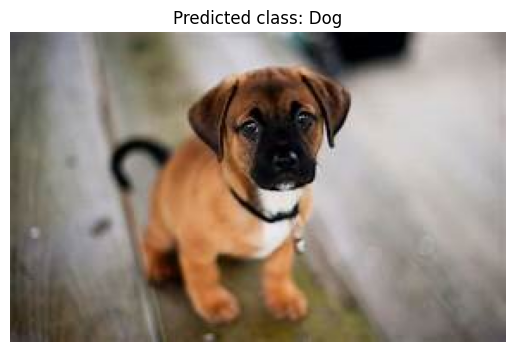

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
# Load the trained weights into the model
model = MediumDeepNet('relu')  # Assuming 'relu' activation was used during training
model.load_state_dict(torch.load('/content/model_relu_momentum0_scheduler_<torch.optim.lr_scheduler.StepLR object at 0x7deed3bb5ba0>.pth'))  # Load the trained weights

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize image to match input size of CIFAR-10
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image
])

# Load and preprocess the image
image_path = '/content/th.jpg'
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Make predictions
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output = model(image_tensor)

# Get the predicted class label
_, predicted = torch.max(output, 1)
predicted_class = predicted.item()
# Define the class names corresponding to CIFAR-10 classes
class_names = [
    'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
    'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
]

# Assuming predicted_class is the index of the predicted class
predicted_class_name = class_names[predicted_class]



# Display the image
plt.imshow(image)
plt.axis('off')
plt.title(f'Predicted class: {predicted_class_name}')
plt.show()

Predicted class: Dog
